In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import norm
from collections import Counter
from time import time
from matplotlib import collections  as mc


import deerhelp
import optpath

sns.set_style('whitegrid')

In [2]:
df = pd.read_csv("cities.csv")
coordinates = np.array([df.X, df.Y])
coordsT = np.array([df.X, df.Y]).T 
nb_cities = max(df.CityId)

primes = deerhelp.sieve_eratosthenes(nb_cities)
prime_ids = np.array(range(len(primes)))[primes == 1]
df['Prime'] = primes

city_square = df

In [3]:
city_square.head()

,CityId,X,Y,Prime
0,0,316.836739,2202.340707,0
1,1,4377.405972,336.602082,0
2,2,3454.158198,2820.053011,1
3,3,4688.099298,2935.898056,1
4,4,1010.696952,3236.750989,0


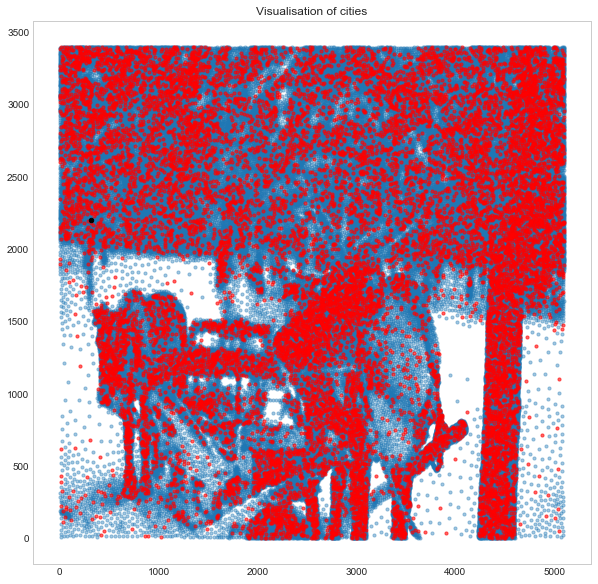

In [4]:
plt.figure(figsize=(10, 10))
plt.scatter(city_square[city_square['Prime'] == 0].X, 
            city_square[city_square['Prime'] == 0].Y, s=10, alpha=0.4)
plt.scatter(city_square[city_square['Prime'] == 1].X, 
            city_square[city_square['Prime'] == 1].Y, s=10, alpha=0.6, c='red')
plt.scatter(city_square.iloc[0: 1, 1], city_square.iloc[0: 1, 2], s=20, c="black")
plt.grid(False)
plt.title('Visualisation of cities')
plt.show()

# generate mini tour

In [5]:
mini_coordinates = np.array([city_square.X, city_square.Y])

mini_path_coords = np.array([ mini_coordinates[:,point] for point in np.array(pd.read_csv("TSP_approx_sol.csv").Path) ])

mini_df_pre = pd.DataFrame({'X': mini_path_coords[:,0],
                            'Y':mini_path_coords[:,1],
                            'path_pre': range(len(mini_path_coords[:,1]))})
merged_df = city_square.merge(mini_df_pre, how = 'inner', on = ['X', 'Y'])

mini_path = np.array(merged_df.sort_values('path_pre').CityId)
mini_path = np.append(mini_path,[0])

#pd.DataFrame({'Path':path}).to_csv('test_1.csv',index  = False)

In [6]:
nn_array = optpath.find_nn(np.array([df.X, df.Y]).T, 8)

In [7]:
nn_array

array([[ 78934,  97580,      0, ..., 137367, 186667, 177242],
       [ 83015, 172970,   2349, ...,  33577,  50936, 146846],
       [ 49203,  54351,      2, ..., 121482, 112713,   7734],
       ...,
       [197766,  75934,  29644, ...,  55482,  52063, 126806],
       [ 55722,  95927, 128774, ..., 179035,  88649,  17441],
       [162332, 143747, 197768, ...,  15553,  57941,  79587]])

In [8]:
def plot_path(path,coordinates,fname):
    # Plot tour
    lines = [[coordinates[: ,path[i-1]], coordinates[:, path[i]]] for i in range(1, len(path)-1)]
    lc = mc.LineCollection(lines, linewidths=1.0)
    line_f = [[coordinates[: ,path[len(path)-2]], coordinates[:, path[len(path)-1]]]]
    lc_f = mc.LineCollection(line_f, linewidths=1.0,linestyles='dashed')
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_aspect('equal')
    plt.grid(False)
    ax.add_collection(lc)
    ax.add_collection(lc_f)
    ax.scatter(city_square[city_square['Prime'] == 0].X, 
            city_square[city_square['Prime'] == 0].Y, s=10)
    ax.scatter(city_square[city_square['Prime'] == 1].X, 
            city_square[city_square['Prime'] == 1].Y, s=40, c='red')
    ax.scatter(coordinates.T[tenth_cities(path)].T[0],
            coordinates.T[tenth_cities(path)].T[1], s=20, c='black')
    ax.scatter(city_square.iloc[0: 1, 1], city_square.iloc[0: 1, 2], s=50, c="black", marker='*')
    ax.autoscale()
    fig.savefig(fname+".png", bbox_inches='tight')
    return ax

# Scoring function

In [10]:


def path_lens_2(path):
    
    coordsT = np.array([df.X, df.Y]).T 
    primes_on_path = np.array(df.iloc[path].Prime) 
    coord_diff = coordsT[path][0:-1]-coordsT[path][1:]
    coord_diff_sq = np.multiply(coord_diff, coord_diff)
    dists = np.sqrt(coord_diff_sq[:,0]+coord_diff_sq[:,1])

    dists_penal = dists.copy()
    for i in range(10,len(path),10):
        if not primes_on_path[i-1]:
            dists_penal[i-1] *= 1.1

    return (np.sum(dists),np.sum(dists_penal))
    
tic = time()
print path_lens_2(mini_path)
toc=time()
print toc-tic

(1503293.397774147, 1516912.3751145517)
0.0702948570251


In [11]:
cities_p = np.array(df.Prime)

def path_lens(path):
    
#     if os.path.isfile('cities_p.npy'):
#         nn_array = np.load('cities_p.npy')
    
#     else:
    # Remove trailing home city, if present
    if path[-1] == path[0]:
        path = path[:-1]
    # Permute matrix to path ordering
    xy = coordinates.T[path, :]
    distances = np.sqrt(np.sum(np.square(xy - np.roll(xy, -1, axis=0)),axis=1))
    # Extract out prime status for every 10th starting city
    p = cities_p[path[9::10]]
    p_multiplier = np.where(p, 1.0, 1.1)
    # Scale up relevant routes
    distances[9::10] *= p_multiplier
    return distances.sum()

In [12]:
tic = time()
print path_lens(mini_path)
toc = time()

print toc-tic


1516912.3751145517
0.0140240192413


# helper functions for iterating deformations

In [13]:
def get_unique_best_paths(paths, N):

    sorted_paths = [ paths[n] for n in np.argsort(map(lambda x: path_lens(x), paths)) ]

    unique_paths = []
    count = 0
    while len(unique_paths) < N:
    
        if not any((sorted_paths[count] == x).all() for x in unique_paths):
    
            unique_paths = unique_paths + [sorted_paths[count]]
        
        count += 1
    
    return unique_paths

In [14]:
def one_step_primes(path):
    
    '''find positions of one-step primes in list'''
    
    add_step=[]
    rem_step=[]
    for p in range(9,len(path),10):
        if path[p+1] in prime_ids:
            # all primes that are one step ahead of tenth-cities 
            # (want to remove a point before)
            rem_step.append(p+1)
        if path[p-1] in prime_ids:
            # all primes that are one step behind tenth-cities 
            # (want to add a point before)
            add_step.append(p-1)
            
    return (rem_step,add_step)

In [15]:
def active_primes(path):
    
    '''returns a list with a 1 at the position of each active prime and a zero at all
    other positions.'''
    
    act_prims = np.zeros(len(path))
    for p in range(9,len(path),10):
        if path[p] in prime_ids:
            act_prims[p] = 1
    return act_prims  

In [16]:
def num_active_primes(path):
    return len(np.intersect1d(path[9::10],prime_ids))

In [17]:
def not_overlap_q(d1,d2):
    overlap = (min(d2) <= d1[0] <= max(d2)) or (min(d2) <= d1[1] <= max(d2)) or ( min(d1) <= min(d2) and max(d2) <= max(d1))
    return not overlap

def comp_defs(path_defs):
    compatible_deformations = np.zeros((len(path_defs),len(path_defs)))
    for n1 in range(len(path_defs)):
        for n2 in range(len(path_defs)):
            compatible_deformations[n1,n2] = not_overlap_q(path_defs[n1],path_defs[n2])
    return compatible_deformations

# generating deformations 

In [24]:
def gen_defs(path):
       
    defs = []
    rem_step, add_step = one_step_primes(path)
    act_prims = active_primes(path)
    med_len_for_path = optpath.med_len(mini_path, coordsT)
    
    is_tenth_city = np.zeros(len(path))
    is_tenth_city[9::10] = 1
    
    mini_nn_dict = {}
    for point in mini_path:
        mini_nn_dict[point] = np.setdiff1d(nn_array[point],np.array([point]))  
           
    for p in range(1,len(path)-1):
        
        for nn in mini_nn_dict[path[p]]:
            
            q = np.where(path == nn)[0][0]
            
            if p != q+1 and q!=0:
            
                if p > q: 
                    
                    # [... q-1, q, q+1, ..., p-1, p, p+1]
                    # --------------------------------------
                    
                    # [... a,   b, c,...   , e,   f, g, ...] => 
                    
                    # [... a,   c,...   , e, f,   b, g, ...]
                    
                    del_pure = optpath.delta_pure(path, coordsT,(p,q))
                    primes_lost = np.sum(act_prims[q:p+1])                    
                    primes_gained = np.sum(np.multiply(( q < np.array(rem_step)),(np.array(rem_step) <= p)))
                        
                else:
                    
                    # [... p-1, p, p+1, ..., q-1, q, q+1]
                    # --------------------------------------
                   
                    # [... a,   b, c,...   , e,   f, g, ...]
                   
                    # [... a,   f, b, c,...     , e,   g, ...]
                    
                
                    del_pure = optpath.delta_pure(path,coordsT,(p,q))
                    primes_lost = np.sum(act_prims[p:q+1])
                    primes_gained = np.sum(np.multiply(( p <= np.array(add_step)),(np.array(add_step) < q)))
                    
                if is_tenth_city[p]==1 and primes[nn]==1: 
                    
                    primes_gained += 1
                
                # if no new primes and pure len increases: skip.
                if (primes_lost >= primes_gained)&(del_pure>0):
                    
                    continue 
        
                # if new primes and pure len does not increase more than expected savings:  keep. 
                if (primes_gained >= primes_lost)&(del_pure < 0.1*(primes_gained-primes_lost)*med_len_for_path):
                
                    defs.append((p,q))
            
    return defs

# Iterating 

In [ ]:
its = 0
while its < 10:
    
    # initialize
    if its == 0:
        
        path = mini_path
    
    print 'iteration = ' + str(its)
    print 'current length = ' + str(path_lens(path))
    print 'active primes = ' + str(len(np.intersect1d(path[9::10],prime_ids)))
    
    # generate good deformations of path
    path_defs = np.array(gen_defs(path))
    
    print 'number of good deformations = ' + str(len(path_defs))
    
    # act on path with deformations
    deformed_paths = [ (make_deform(path, d),d) for d in path_defs ]

    # sort deformed paths based on performance
    sorted_defs = path_defs[np.argsort(path_lens(path)-np.array(map(lambda x: path_lens(x[0]), deformed_paths)))[::-1]]
   
    # determine which of good defs are compatible in sorted order
    compatible_deformations = comp_defs(sorted_defs)

    # start with best deformation and add compatible defs
    tot_def = [0]
    more_defs = 1

    while more_defs > 0:
    
        tot_comp_defs = np.prod(compatible_deformations[tot_def].T,axis=1)
        more_defs = np.sum(tot_comp_defs)
    
        if more_defs > 0:
    
            new_def = np.min(np.arange(len(sorted_defs))[ tot_comp_defs ==1 ])
            tot_def.append(new_def)
        
    # make new path using total deformation
    new_path = path
    for d in sorted_defs[tot_def]:
        new_path = make_deform(new_path,d)
    
    path = new_path
    its += 1

iteration = 0
current length = 1516912.3751145517
active primes = 1862
